# Transfer learning

We are going to download a pre-trained model and fine-tune it to a dataset of our choosing.

First, setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

The NN layers can be frozen to prevent them from changing during learning.

When a trainable weight becomes non-trainable, its value is no longer updated during training.



In [ ]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


If you set `trainable = False` on a model or on any layer that has sublayers, all children layers become non-trainable as well.

In [ ]:
inner_model = keras.Sequential(
  [
   keras.layers.InputLayer((3,)),
   keras.layers.Dense(3, activation="relu"),
   keras.layers.Dense(3, activation="relu"),
  ]
)

model = keras.Sequential(
  [keras.layers.InputLayer((3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # Freeze the outer model

print("weights:", len(model.weights))
print("trainable_weights:", len(model.trainable_weights))
print("non_trainable_weights:", len(model.non_trainable_weights))

assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursiv#e

weights: 6
trainable_weights: 0
non_trainable_weights: 6


# Getting the training data
For this example, we will use the `cats vs dogs` dataset.

In [ ]:
train_ds, validation_ds, test_ds = tfds.load(
  "cats_vs_dogs",
  # Reserve 10% for validation and 10% for test
  split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
  as_supervised=True,  # Include labels
)

print(f"# training samples: {tf.data.experimental.cardinality(train_ds)}")
print(f"# validation samples: {tf.data.experimental.cardinality(validation_ds)}")
print(f"# test samples: {tf.data.experimental.cardinality(test_ds)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.2HE6KD_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
# training samples: 9305
# validation samples: 2326
# test samples: 2326


Visualise the data

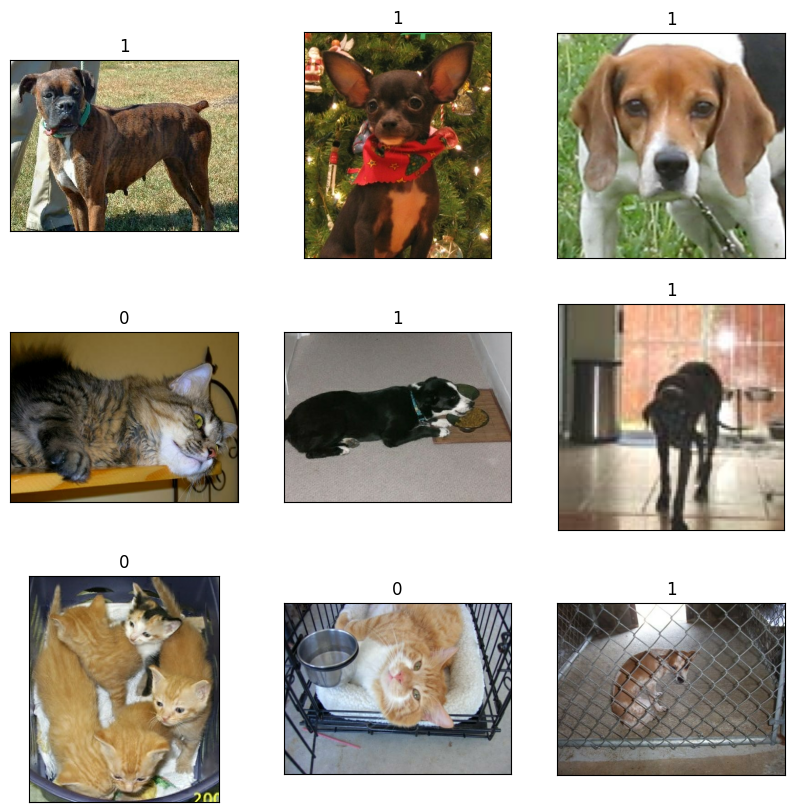

In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis('on')
  plt.xticks([])
  plt.yticks([])

Let's batch data like we did with the MNIST example

In [ ]:
# Resize data
size = (150, 150)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

# Batch data
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

# Data augmentation
In order to improve the generallity of learning, or if the training data is too small or has uniformity in transformations, we often "augment" the training data. Augmentation will include making extra graining examples by taking the existing ones and deforming them or adding some kind of transformation.

Data augmentation increases the size of the training/validation set and introduces variablility.

In this example, we will make a augmentation function that will randomly flip the image and rotate it a bit.

# New section

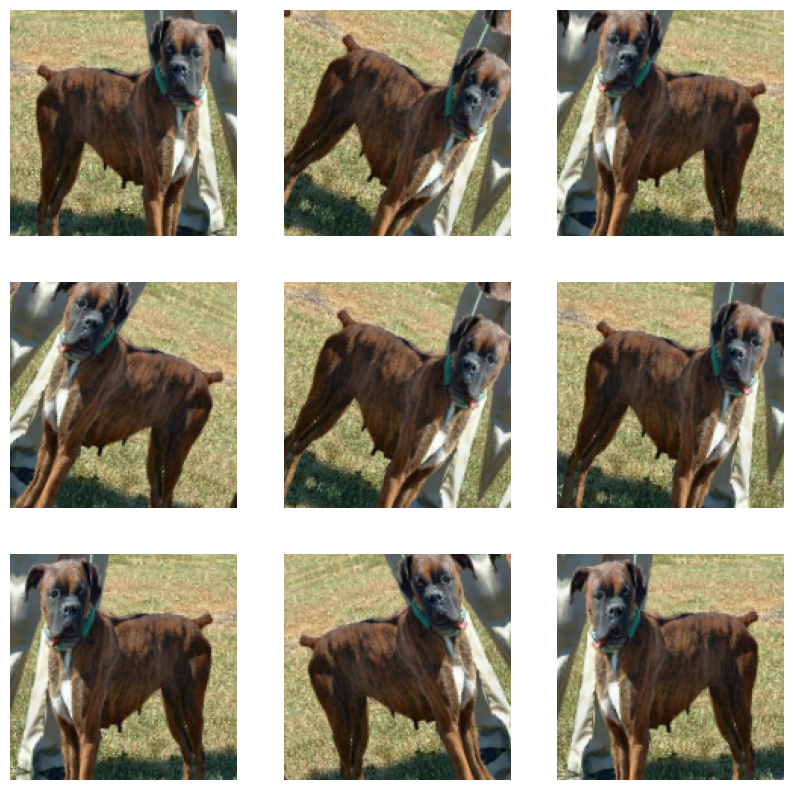

In [ ]:
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
  ])

import numpy as np

for images, labels in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = images[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(
      tf.expand_dims(first_image, 0), training=True
    )
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.axis("off")

## Example transfer learning workflow

1.   Instantiate a base model and load pre-trained weights into it;
2.   Freeze all layers in the base model by setting `trainable = False`;
3.   Create a new model on top of the output of one (or several) layers from the base model.
4.   Train your new model on your new dataset.

The following code is using the "Functional API" to chaing the layers in order to create the model.

This has the same effect as creating a NN model with subclassing:

E.g.
```python
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.dense1(inputs)
    return self.dense2(x)

model = MyModel()
```

In [ ]:
base_model = keras.applications.Xception(
  weights="imagenet",  # Load weights pre-trained on ImageNet.
  input_shape=(150, 150, 3),
  include_top=False, # Do not include the ImageNet classifier at the top.
)

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
# Apply random data augmentation
# In this case, we will just disturb the already existing data
x = data_augmentation(inputs)

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.)
# The normalization layer does the following:
#            outputs = (inputs - mean) / sqrt(var)
mean = np.array([127.5] * 3)
var = mean ** 2
norm_layer = keras.layers.experimental.preprocessing.Normalization(mean=mean, variance=var)
#norm_layer.adapt(x)
#print(norm_layer.weights)
# Scale inputs to [-1, +1]
x = norm_layer(x)
# norm_layer.set_weights([mean, var])


# The base model is not supposed to train, so we will put it into inference mode
#    `training=False`
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), name='tf.keras.backend.print_tensor_4/Identity:0', description="created by layer 'tf.keras.backend.print_tensor_4'")


Now is the time to train the last CNN layers

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss=keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 40s 102ms/step - loss: 0.1631 - binary_accuracy: 0.9308 - val_loss: 0.0816 - val_binary_accuracy: 0.9699
Epoch 2/20
291/291 [==============================] - 24s 83ms/step - loss: 0.1145 - binary_accuracy: 0.9495 - val_loss: 0.0784 - val_binary_accuracy: 0.9729
Epoch 3/20
291/291 [==============================] - 23s 80ms/step - loss: 0.1113 - binary_accuracy: 0.9543 - val_loss: 0.0758 - val_binary_accuracy: 0.9721
Epoch 4/20
291/291 [==============================] - 23s 80ms/step - loss: 0.1061 - binary_accuracy: 0.9550 - val_loss: 0.0754 - val_binary_accuracy: 0.9699
Epoch 5/20
291/291 [==============================] - 23s 80ms/step - loss: 0.1036 - binary_accuracy: 0.9571 - val_loss: 0.0754 - val_binary_accuracy: 0.9712
Epoch 6/20
291/291 [==============================] - 24s 83ms/step - loss: 0.1008 - binary_accuracy: 0.9597 - val_loss: 0.0748 - val_binary_accuracy: 0.9712
Epoch 7/20
291/291 [==============================]

Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.

**Important note:**
Although the base model becomes trainable, it is still running in inference mode since we passed `training=False` when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [ ]:
base_model.trainable = True
model.summary()

model.compile(
  optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
  loss=keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 normalization_5 (Normaliza  (None, 150, 150, 3)       0         
 tion)                                                           
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0   